# False Political Claim Detection

### the task is to predict false claims: fake news. That is, to predict the label attribute

In [1]:
# import 
import pandas as pd
import numpy as np
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, accuracy_score
from sklearn import metrics
import itertools

In [2]:
#Load Dataset
data = pd.read_csv("train.csv")
df = data.copy()
df.head()

id  label                                          statement  \
0  81f884c64a7      1  China is in the South China Sea and (building)...   
1  30c2723a188      0  With the resources it takes to execute just ov...   
2  6936b216e5d      0  The (Wisconsin) governor has proposed tax give...   
3  b5cd9195738      1  Says her representation of an ex-boyfriend who...   
4  84f8dac7737      0  At protests in Wisconsin against proposed coll...   

                                             subject  \
0                      china,foreign-policy,military   
1                                        health-care   
2           corporations,pundits,taxes,abc-news-week   
3  candidates-biography,children,ethics,families,...   
4                     health-care,labor,state-budget   

                      speaker            speaker_job        state_info  \
0                donald-trump        President-Elect          New York   
1                  chris-dodd           U.S. senator       Connecticut   
2               donna-brazile  Political commentator  Washington, D.C.   
3             rebecca-bradley                    NaN               NaN   
4  republican-party-wisconsin                    NaN         Wisconsin   

  party_affiliation  
0        republican  
1          democrat  
2          democrat  
3              none  
4        republican

We define the train and test dataset:

In [3]:
test = pd.read_csv("test_nolabel.csv")
train = data.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 8950 non-null   object
 1   label              8950 non-null   int64 
 2   statement          8950 non-null   object
 3   subject            8950 non-null   object
 4   speaker            8950 non-null   object
 5   speaker_job        6469 non-null   object
 6   state_info         7021 non-null   object
 7   party_affiliation  8950 non-null   object
dtypes: int64(1), object(7)
memory usage: 559.5+ KB


### Data Fields

- id: the ID of the statement
- label: the label of the statement; 0 if true, 1 if false
- statement: the statement itself, in text
- subject: the subject(s) discussed in the statement
- speaker: the speaker, who made the claim
- speaker_job: the speaker's job title
- state_info: the state info, where the claim was made
- party_affiliation: the party affiliation

In [5]:
train.shape

(8950, 8)

In [6]:
test.shape

(3836, 7)

# Dataset analysis

### Types of Values

<AxesSubplot:ylabel='None'>

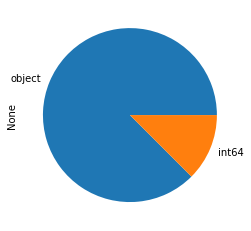

In [7]:
df.dtypes.value_counts().plot.pie()

The values of type int64 is only the 'label' column.

### Proportion of real and fake information

D:\Annaconda\envs\tensorflow_env\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
D:\Annaconda\envs\tensorflow_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


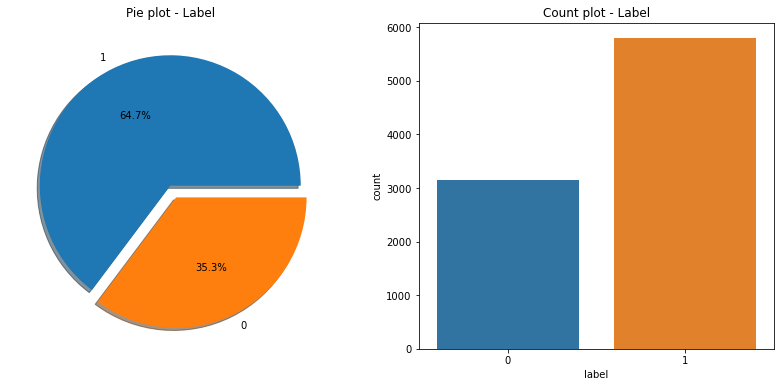

In [8]:
f,ax = plt.subplots(1,2,figsize=(14,6))
df['label'].value_counts().plot.pie(explode=[0, 0.1],autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Label')
ax[0].set_ylabel('')
sns.countplot('label', data = df, ax=ax[1])
ax[1].set_title('Count plot - Label')
plt.show()

We can see that there is 35.3% of real news and 64.7% of fake news.

### Missing Values

In [9]:
print(train.isnull().sum())
print(test.isnull().sum())

id                      0
label                   0
statement               0
subject                 0
speaker                 0
speaker_job          2481
state_info           1929
party_affiliation       0
dtype: int64
id                      0
statement               0
subject                 0
speaker                 0
speaker_job          1082
state_info            817
party_affiliation       0
dtype: int64


We fill NULL values with empty string:

In [10]:
train=train.fillna('')
test=test.fillna('')

# Relation Target (Label) / Variables

We divide the dataset in two parts: a part with real News (df_true) and a part with fake News (df_fake).

In [11]:
df_true = df[df['label'] == 0]
df_fake = df[df['label'] == 1]

In this part we are going to use plotly to plot some graphics, they are more detailed and you can zoom in.

### Variable Subject

In [12]:
import plotly.express as px
# Here we use a column with categorical data
fig = px.histogram(df, x='subject', color='label', title='Proportion of subjects')
fig.show()

We can notice that some subjects have a rate of real news very high compare to the others subjects.

Let's see which one : 

In [13]:
df_true.subject.value_counts().sort_values(ascending=False)

elections                                                                            96
taxes                                                                                94
health-care                                                                          91
education                                                                            88
immigration                                                                          66
                                                                                     ..
candidates-biography,children,crime,criminal-justice,families,public-safety,women     1
census,families,income,poverty,wealth                                                 1
elections,government-regulation                                                       1
gambling,jobs,state-budget,taxes                                                      1
candidates-biography,diversity,elections                                              1
Name: subject, Length: 1447, dty

Thus the subjects elctions, taxes, health-care, education, immigration have a rate of real news very high in this dataset.

Let's see these subjects in the fake new dataset.

In [14]:
df_fake.subject.value_counts().sort_values(ascending=False)

health-care                                             250
immigration                                             158
taxes                                                   150
elections                                               129
education                                               113
                                                       ... 
energy,abc-news-week                                      1
education,stimulus                                        1
federal-budget,health-care,terrorism                      1
health-care,job-accomplishments,message-machine-2012      1
elections,history,human-rights,legal-issues               1
Name: subject, Length: 2486, dtype: int64

These subject have also a very high rate in the fake news dataset, thus we can't conclude anything from it.

### Variable Speaker

In [15]:
import plotly.express as px
# Here we use a column with categorical data
fig = px.histogram(df, x='speaker', color='label', title='Proportion of speaker')
fig.show()

Some speakers appear more than others, let's see which one :

In [16]:
df_true.speaker.value_counts().sort_values(ascending=False)

barack-obama                       202
hillary-clinton                    106
john-mccain                         57
bernie-s                            43
scott-walker                        43
                                  ... 
cliff-stearns                        1
north-carolina-republican-party      1
doreen-costa                         1
alan-simpson                         1
catherine-taylor                     1
Name: speaker, Length: 1280, dtype: int64

Let's see if these speakers appear in the fake news dataset.

In [17]:
df_fake.speaker.value_counts().sort_values(ascending=False)

barack-obama       233
donald-trump       206
chain-email        124
mitt-romney        102
hillary-clinton     98
                  ... 
richard-besser       1
pete-snyder          1
allan-ritter         1
james-woods          1
amy-handlin          1
Name: speaker, Length: 1984, dtype: int64

Thanks to the graphic we know that :

- Donald trump appears **41** times in the real news dataset and **206** times in the fake news dataset.
- Chain-email appears **4** times in the real news dataset and **124** times in the fake news dataset.
- Mitt-romney appears **40** times in the real news dataset and **102** times in the fake news dataset.

### Variable Speaker job

In [18]:
import plotly.express as px
# Here we use a column with categorical data
fig = px.histogram(df, x="speaker_job", color='label', title='Proportion of speaker job')
fig.show()

In [19]:
df_true.speaker_job.value_counts().sort_values(ascending=False)

President                                                  203
U.S. Senator                                               181
Governor                                                   112
Presidential candidate                                     109
U.S. senator                                               102
                                                          ... 
Editor of Reason.com                                         1
Pro-gambling group                                           1
executive director, Center for Public Policy Priorities      1
Editorial director, Huffington Post                          1
U.S. Secretary of Education                                  1
Name: speaker_job, Length: 583, dtype: int64

In [20]:
df_fake.speaker_job.value_counts().sort_values(ascending=False)

President                                     235
Governor                                      223
U.S. Senator                                  210
President-Elect                               206
U.S. senator                                  134
                                             ... 
Tompkins County legislator                      1
Professor, Texas State University               1
Electioneering communications organization      1
Wine writer and consultant                      1
El Paso County Commissioner                     1
Name: speaker_job, Length: 807, dtype: int64

We find the same proportions of speaker_job in the real news dataset than the fake news dataset.

Thus, we can't really draw any conclusions about the variable Speaker job.

### Variable State_info

<AxesSubplot:ylabel='state_info'>

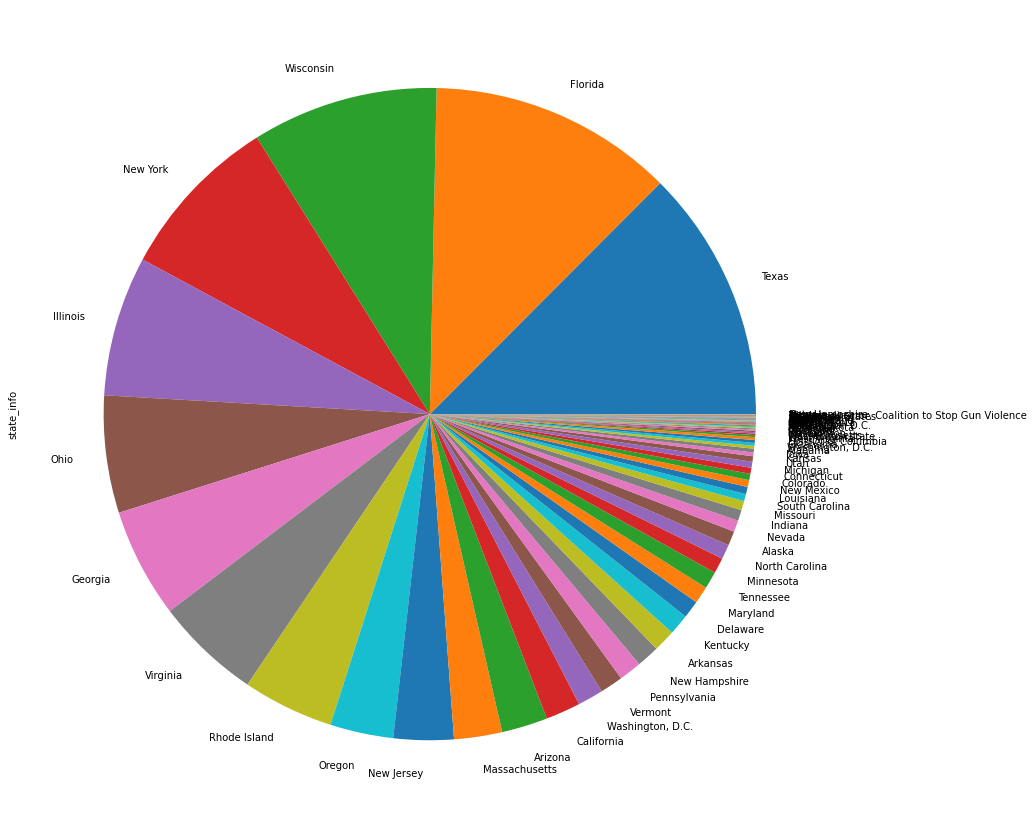

In [21]:
plt.figure(figsize=(15,15))
df['state_info'].value_counts().plot.pie()

We can notice that there are many state in the dataset but a large part comes from the Texas, Florida, Wisconsin, New York, Illinois, Ohio..

In [22]:
import plotly.express as px
# Here we use a column with categorical data
fig = px.histogram(df, x="state_info", color='label', title='Proportion of State_info')
fig.show()

In [23]:
df_true.state_info.value_counts().sort_values(ascending=False)

Florida      326
Texas        304
Illinois     217
Ohio         197
Wisconsin    192
            ... 
Colorado       1
Georgia        1
Virginia       1
Nebraska       1
Atlanta        1
Name: state_info, Length: 62, dtype: int64

In [24]:
df_fake.state_info.value_counts().sort_values(ascending=False)

Texas         575
Florida       527
Wisconsin     456
New York      390
Illinois      270
             ... 
Wisconsin       1
Oregon          1
Virgina         1
Hawaii          1
Montana         1
Name: state_info, Length: 71, dtype: int64

Thanks to the graphic we know that :
    
- Wisconsin appears **192** times in the real news dataset and **456** times in the fake news dataset.
- New York appears **189** times in the real news dataset and **390** times in the fake news dataset.
- Illinois appears **217** times in the real news dataset and **102** times in the fake news dataset.

However, it must be kept in mind that there is 35.3% of real news and 64.7% of fake news.

### Variable party_affiliation

In [25]:
import plotly.express as px
# Here we use a column with categorical data
fig = px.histogram(df, x="party_affiliation", color='label', title='Proportion of party affiliation')
fig.show()

We can notice that the Replubican part has many fake news in this dataset.

### Variable Statement

Let's see with wordcloud the most frequent word in both dataset:

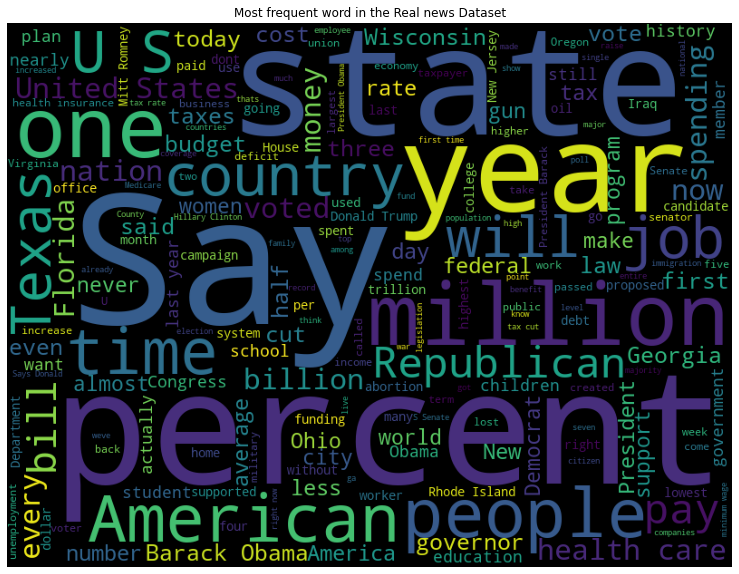

In [26]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', width=800, height=600)
wordcloud = wordcloud.generate(' '.join(df_true['statement']))


plt.figure(figsize=(15,10))
plt.title('Most frequent word in the Real news Dataset')
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

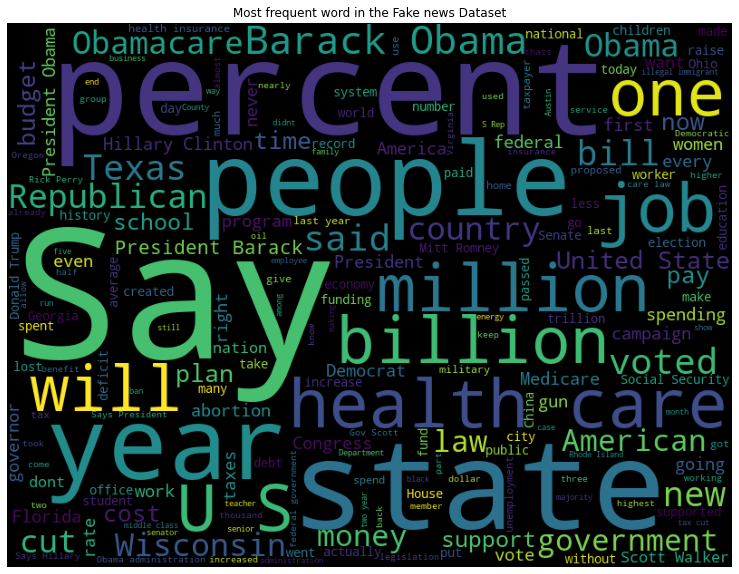

In [27]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', width=800, height=600)
wordcloud = wordcloud.generate(' '.join(df_fake['statement']))



plt.figure(figsize=(15,10))
plt.title('Most frequent word in the Fake news Dataset')
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

We can notice that we find similar words in the two dataset.

## Feature engineering

We create a new independent variable by concatenating 'statement' and 'speakers'.
#This new independent variable would be perform better in classifying the real and fake news instead of taking an individual variable.Will use this new independent variable in building the model.

In [28]:
train['general'] = train['statement']+' '+ train['subject']
test['general']= test['statement']+' '+ test['subject']

We drop the label column from the train set: 

In [29]:
X = train.drop(['label'],axis=1)

Y = train['label']

### Text Preprocessing

- Removing special characters and numbers 
- Converting into lowercase to develop a consistent data
- Tokenize the statement, ignoring stopwords and performing stemming on the words

In [30]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [31]:
# Training data

corpus_train=[]

for i in range(len(X)):
    input = re.sub('[^a-zA-Z]',' ',X['general'][i]) # except a-z and A-Z, substitute all other characters with ' '
    input = input.lower() # Lower case 
    input  = input.split() # tokenize the text
    input = [ps.stem(word) for word in input if word not in stopwords.words('english')] # ignoring stopwords and stemming rest of the words
    text = ' '.join(input)  # concatenating all words into a single text (list is created)#
    corpus_train.append(text) # appending text into a single corpus #
len(corpus_train)

8950

### Preprocessed text 

Let's see the corpus_train to see how it looks like:

In [32]:
print(corpus_train[0])
print(corpus_train[1])
print(corpus_train[2])
print(corpus_train[3])
print(corpus_train[4])

china south china sea build militari fortress like perhap world seen china foreign polici militari
resourc take execut three month iraq war could fulli fund expans health care needi children bush veto health care
wisconsin governor propos tax giveaway corpor corpor pundit tax abc news week
say represent ex boyfriend friend famili law case someth lawyer regular basi candid biographi children ethic famili legal issu
protest wisconsin propos collect bargain chang phoni sick note pass excus strike union member health care labor state budget


In [33]:
# Test Data


corpus_test=[]

for i in range(len(test)):
    input = re.sub('[^a-zA-Z]',' ',test['general'][i]) # except a-z and A-Z, substitute all other characters with ' '
    input = input.lower()
    input  = input.split() # tokenize the text
    input = [ps.stem(word) for word in input if word not in stopwords.words('english')] # ignoring stopwords and stemming rest of the words
    text = ' '.join(input)  # concatenating all words into a single text (list is created)#
    corpus_test.append(text) # appending text into a single corpus #
len(corpus_test)

3836

In [34]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

## First Method : CountVectorizer

In [35]:
messages=df.copy()
messages.reset_index(inplace=True)

We create first the bag of Words model.

In [36]:
cv = CountVectorizer(max_features=5000,ngram_range=(1,3))
X = cv.fit_transform(corpus_train).toarray()


In [37]:
X.shape

(8950, 5000)

In [38]:
y= messages['label']

In [39]:
## Divide the dataset into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [40]:
cv.get_feature_names()[:20]

['abbott',
 'abc',
 'abc news',
 'abc news week',
 'abel',
 'abil',
 'abl',
 'abolish',
 'abort',
 'abort abort',
 'abort abort health',
 'abort abort messag',
 'abort candid',
 'abort candid biographi',
 'abort children',
 'abort congress',
 'abort correct',
 'abort correct updat',
 'abort crime',
 'abort even']

In [41]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [42]:
count_df = pd.DataFrame(X_train, columns=cv.get_feature_names())

In [43]:
count_df.head()

abbott  abc  abc news  abc news week  abel  abil  abl  abolish  abort  \
0       0    0         0              0     0     0    0        0      0   
1       0    0         0              0     0     0    0        0      0   
2       0    0         0              0     0     0    0        0      0   
3       0    0         0              0     0     0    0        0      0   
4       0    0         0              0     0     0    0        0      0   

   abort abort  ...  young  young peopl  your  your go  youth  youv  youv got  \
0            0  ...      0            0     0        0      0     0         0   
1            0  ...      0            0     0        0      0     0         0   
2            0  ...      0            0     0        0      0     0         0   
3            0  ...      0            0     0        0      0     0         0   
4            0  ...      0            0     0        0      0     0         0   

   zero  zika  zone  
0     0     0     0  
1     0     0     0  
2     0     0     0  
3     0     0     0  
4     0     0     0  

[5 rows x 5000 columns]

In [44]:
count_df.shape

(5996, 5000)

In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [46]:
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()

accuracy:   0.614
Confusion matrix, without normalization


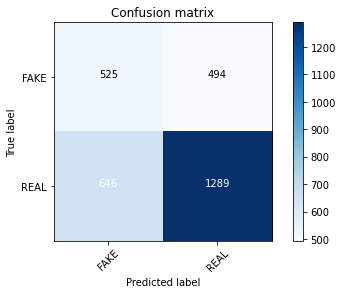

In [47]:
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [48]:
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
score

0.6140825998645904

## Second Method : TFidf Vectorizer

In [50]:
tfidf_v=TfidfVectorizer(max_features=5000,ngram_range=(1,3))
X=tfidf_v.fit_transform(corpus_train).toarray()

In [51]:
X.shape

(8950, 5000)

In [52]:
y=messages['label']

In [53]:
## Divide the dataset into Train and Test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [54]:
tfidf_v.get_feature_names()[:20]

['abbott',
 'abc',
 'abc news',
 'abc news week',
 'abel',
 'abil',
 'abl',
 'abolish',
 'abort',
 'abort abort',
 'abort abort health',
 'abort abort messag',
 'abort candid',
 'abort candid biographi',
 'abort children',
 'abort congress',
 'abort correct',
 'abort correct updat',
 'abort crime',
 'abort even']

In [55]:
tfidf_v.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [56]:
count_df = pd.DataFrame(X_train, columns=tfidf_v.get_feature_names())

In [57]:
count_df.head()

abbott  abc  abc news  abc news week  abel  abil  abl  abolish  abort  \
0     0.0  0.0       0.0            0.0   0.0   0.0  0.0      0.0    0.0   
1     0.0  0.0       0.0            0.0   0.0   0.0  0.0      0.0    0.0   
2     0.0  0.0       0.0            0.0   0.0   0.0  0.0      0.0    0.0   
3     0.0  0.0       0.0            0.0   0.0   0.0  0.0      0.0    0.0   
4     0.0  0.0       0.0            0.0   0.0   0.0  0.0      0.0    0.0   

   abort abort  ...  young  young peopl  your  your go  youth  youv  youv got  \
0          0.0  ...    0.0          0.0   0.0      0.0    0.0   0.0       0.0   
1          0.0  ...    0.0          0.0   0.0      0.0    0.0   0.0       0.0   
2          0.0  ...    0.0          0.0   0.0      0.0    0.0   0.0       0.0   
3          0.0  ...    0.0          0.0   0.0      0.0    0.0   0.0       0.0   
4          0.0  ...    0.0          0.0   0.0      0.0    0.0   0.0       0.0   

   zero  zika  zone  
0   0.0   0.0   0.0  
1   0.0   0.0   0.0  
2   0.0   0.0   0.0  
3   0.0   0.0   0.0  
4   0.0   0.0   0.0  

[5 rows x 5000 columns]

In [58]:
count_df.shape

(5996, 5000)

### MultinomialNB Algorithm

In [59]:
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()

accuracy:   0.658
Confusion matrix, without normalization


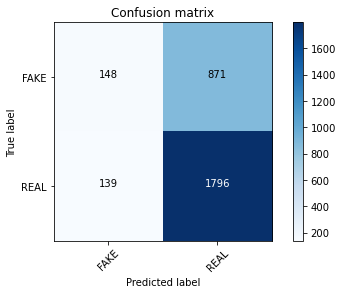

In [60]:
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [61]:
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
score

0.6580907244414353

In [62]:
y_train.shape

(5996,)

### Passive Aggressive Classifier Algorithm

In [63]:
from sklearn.linear_model import PassiveAggressiveClassifier

In [64]:
linear_clf = PassiveAggressiveClassifier()

accuracy:   0.586
Confusion matrix, without normalization


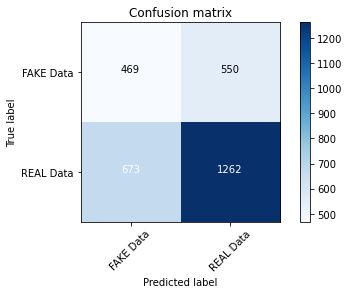

In [65]:
linear_clf.fit(X_train, y_train)
pred = linear_clf.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

### Multinomial Classifier with Hyperparameter

In [66]:
classifier=MultinomialNB(alpha=0.1)

In [67]:
previous_score=0
for alpha in np.arange(0,1,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(X_train,y_train)
    y_pred=sub_classifier.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    if score>previous_score:
        classifier=sub_classifier
    print("Alpha: {}, Score : {}".format(alpha,score))

D:\Annaconda\envs\tensorflow_env\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning:

alpha too small will result in numeric errors, setting alpha = 1.0e-10



Alpha: 0.0, Score : 0.6320243737305349
Alpha: 0.1, Score : 0.6384563303994584
Alpha: 0.2, Score : 0.6425186188219364
Alpha: 0.30000000000000004, Score : 0.6455653351387949
Alpha: 0.4, Score : 0.6496276235612729
Alpha: 0.5, Score : 0.6499661475964793
Alpha: 0.6000000000000001, Score : 0.6492890995260664
Alpha: 0.7000000000000001, Score : 0.6519972918077184
Alpha: 0.8, Score : 0.6550440081245769
Alpha: 0.9, Score : 0.6567366283006093


In [68]:
## Get Features names
feature_names = tfidf_v.get_feature_names()

In [69]:
classifier.coef_[0]

array([-9.13424349, -7.56801545, -7.60727409, ..., -8.14852946,
       -8.89730546, -9.67697775])

In [70]:
### Most real
sorted(zip(classifier.coef_[0], feature_names), reverse=True)[:20]

[(-5.225392175119623, 'say'),
 (-5.277265987813622, 'health'),
 (-5.295827479422308, 'tax'),
 (-5.326890960383361, 'state'),
 (-5.38706624909369, 'care'),
 (-5.400510031810748, 'job'),
 (-5.447762558528439, 'health care'),
 (-5.475197524786564, 'budget'),
 (-5.754016638587891, 'economi'),
 (-5.762828020385918, 'obama'),
 (-5.815426479276938, 'immigr'),
 (-5.852929509752123, 'feder'),
 (-5.864942431983639, 'year'),
 (-5.894281092888857, 'educ'),
 (-5.89847885551573, 'percent'),
 (-5.96933349726857, 'candid'),
 (-5.974125624364716, 'govern'),
 (-5.981964524842645, 'vote'),
 (-6.010879253432947, 'elect'),
 (-6.055280542237026, 'presid')]

In [71]:
### Most fake
sorted(zip(classifier.coef_[0], feature_names))[:5000]

[(-9.968626057269748, 'academi'),
 (-9.968626057269748, 'accommod'),
 (-9.968626057269748, 'american dont'),
 (-9.968626057269748, 'anywher els'),
 (-9.968626057269748, 'averag wage'),
 (-9.968626057269748, 'basketbal'),
 (-9.968626057269748, 'bid'),
 (-9.968626057269748, 'burn'),
 (-9.968626057269748, 'candid governor'),
 (-9.968626057269748, 'chemic'),
 (-9.968626057269748, 'childhood'),
 (-9.968626057269748, 'children poverti'),
 (-9.968626057269748, 'connecticut'),
 (-9.968626057269748, 'disclos'),
 (-9.968626057269748, 'divers economi job'),
 (-9.968626057269748, 'divers histori'),
 (-9.968626057269748, 'donald trump support'),
 (-9.968626057269748, 'donald trump want'),
 (-9.968626057269748, 'drunk'),
 (-9.968626057269748, 'drunk drive'),
 (-9.968626057269748, 'energi nuclear'),
 (-9.968626057269748, 'entir economi'),
 (-9.968626057269748, 'fort worth'),
 (-9.968626057269748, 'golf'),
 (-9.968626057269748, 'health insur program'),
 (-9.968626057269748, 'highest corpor'),
 (-9.968

### Third method HashingVectorizer

In [73]:
hs_vectorizer=HashingVectorizer(n_features=5000, alternate_sign=False)
X=hs_vectorizer.fit_transform(corpus_train).toarray()

In [74]:
X.shape

(8950, 5000)

In [75]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [76]:
## Divide the dataset into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

accuracy:   0.658
Confusion matrix, without normalization


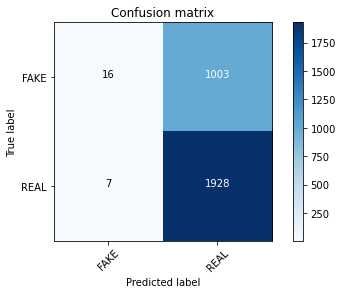

In [77]:
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

## Fourth method LSTM Model

In [78]:
voc_size =10000
onehot_rep_train = [one_hot(words,voc_size)for words in corpus_train]
onehot_rep_test = [one_hot(words,voc_size)for words in corpus_test]

In [79]:
# Train dataset #
# Find out the maximum length of the sentence in the corpus so that we will pad all sentences to that length

c=[]
for i in range(len(train)):
    m=len(train['general'][i].split())
    c.append(m)

print('Maximum length of a sentence is : ',max(c))
print('Average length of a sentence is : ',sum(c)/len(c))

Maximum length of a sentence is :  468
Average length of a sentence is :  19.062793296089385


In [80]:
# Test dataset #
# Find out the maximum length of the sentence in the corpus so that we will pad all sentences to that length

c=[]
for i in range(len(test)):
    m=len(test['general'][i].split())
    c.append(m)

print('Maximum length of a sentence is : ',max(c))
print('Average length of a sentence is : ',sum(c)/len(c))

Maximum length of a sentence is :  432
Average length of a sentence is :  18.97210636079249


In [81]:
# Pad_sequences in order to make all sentences of equal lenghts of 468

embedded_docs_train = pad_sequences(onehot_rep_train,padding='pre',maxlen=468)
embedded_docs_test = pad_sequences(onehot_rep_test,padding='pre',maxlen=468)

In [89]:
embedded_docs_test

array([[   0,    0,    0, ..., 2303, 3182, 3990],
       [   0,    0,    0, ..., 1094, 1432, 4995],
       [   0,    0,    0, ..., 1979, 4073, 2930],
       ...,
       [   0,    0,    0, ...,  483, 2930, 2054],
       [   0,    0,    0, ..., 4305,  627, 2678],
       [   0,    0,    0, ..., 1736,  168, 4743]])

### Building the LSTM Model

In [82]:
# Building an LSTM Model with an embedding layer #
model = Sequential()
model.add(Embedding(voc_size,40,input_length=74))  # 40 : dimension of each vector, input_length : sentence length
model.add(Dropout(0.3))
model.add(LSTM(100))  # 100 memory cells / Neurons 
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))  # sigmoid will help in classifying news as fake or real
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 74, 40)            200000    
_________________________________________________________________
dropout (Dropout)            (None, 74, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [83]:
#Converting into numpy array
train_final = np.array(embedded_docs_train)
y_final = np.array(Y)
test_final = np.array(embedded_docs_test)
print(train_final.shape,y_final.shape,test_final.shape)

(8950, 468) (8950,) (3836, 468)


In [84]:
#training model
model.fit(train_final,y_final,epochs=5,batch_size=150)

Epoch 1/5
60/60 [==============================] - 54s 894ms/step - loss: 0.6579 - accuracy: 0.6431
Epoch 2/5
60/60 [==============================] - 67s 1s/step - loss: 0.6242 - accuracy: 0.6553
Epoch 3/5
60/60 [==============================] - 69s 1s/step - loss: 0.5762 - accuracy: 0.6961
Epoch 4/5
60/60 [==============================] - 71s 1s/step - loss: 0.5408 - accuracy: 0.7250
Epoch 5/5
60/60 [==============================] - 70s 1s/step - loss: 0.5071 - accuracy: 0.7473


In [85]:
y_pred = model.predict_classes(test_final)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


### Building the Bi-LSTM Model

In [86]:
# Building an LSTM Model with an embedding layer #
model1 = Sequential()
model1.add(Embedding(voc_size,40,input_length=74))  # 40 : dimension of each vector, input_length : sentence length
model1.add(Dropout(0.3))
model1.add(Bidirectional(LSTM(100)))  # 100 memory cells / Neurons 
model1.add(Dropout(0.3))
model1.add(Dense(64,activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))  # sigmoid will help in classifying news as fake or real
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 74, 40)            200000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 74, 40)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               112800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                12864     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [87]:
# training model
model1.fit(train_final,y_final,epochs=5,batch_size=100)

Epoch 1/5
90/90 [==============================] - 349s 4s/step - loss: 0.6525 - accuracy: 0.6470
Epoch 2/5
90/90 [==============================] - 356s 4s/step - loss: 0.6126 - accuracy: 0.6658
Epoch 3/5
90/90 [==============================] - 357s 4s/step - loss: 0.5635 - accuracy: 0.7082
Epoch 4/5
90/90 [==============================] - 356s 4s/step - loss: 0.5172 - accuracy: 0.7507
Epoch 5/5
90/90 [==============================] - 355s 4s/step - loss: 0.4734 - accuracy: 0.7788


In [88]:
y_pred = model1.predict_classes(test_final)